/home/zeming/anaconda3/envs/cnnradiomics/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


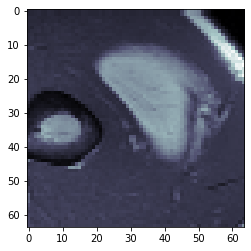

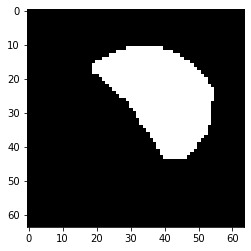

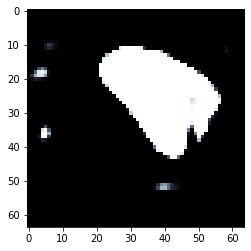

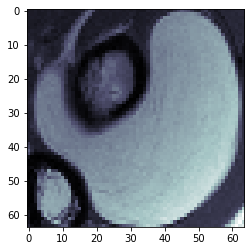

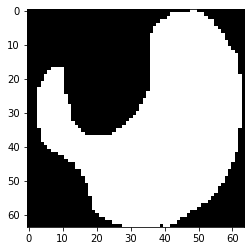

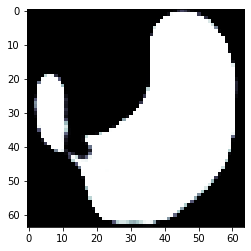

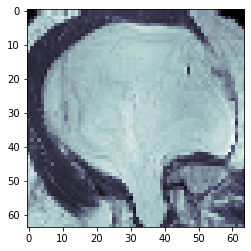

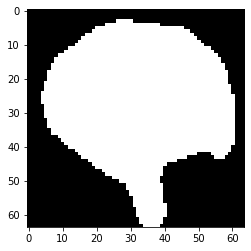

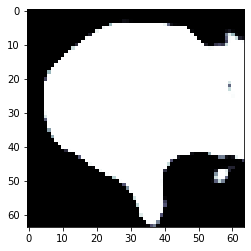

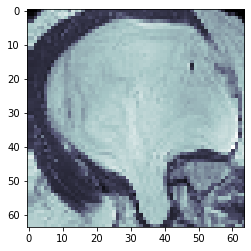

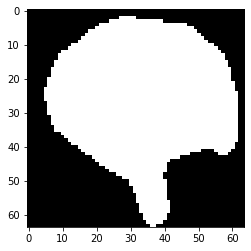

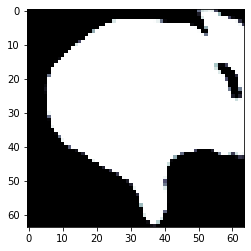

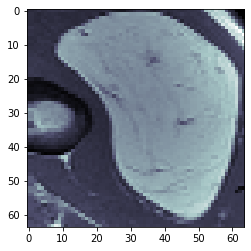

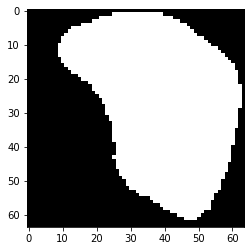

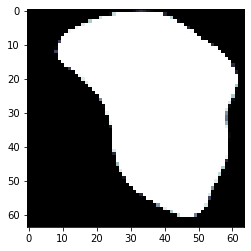

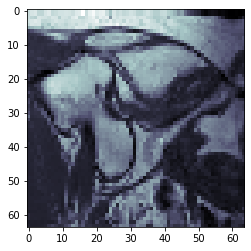

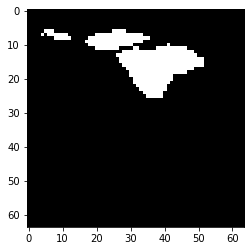

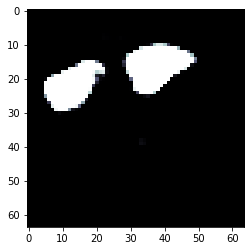

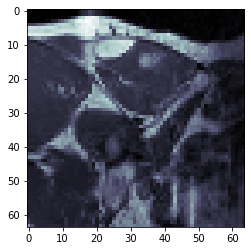

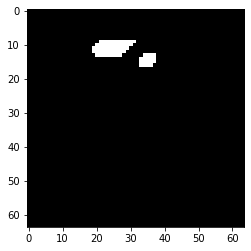

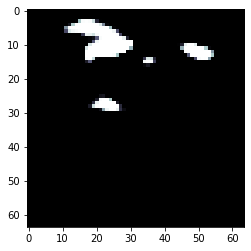

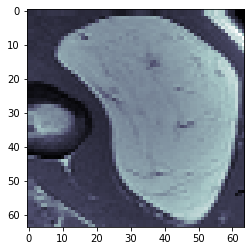

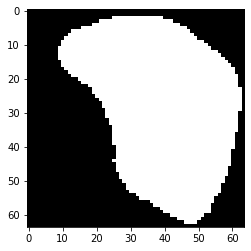

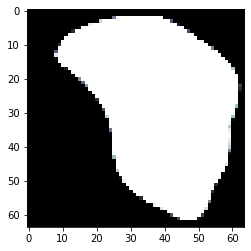

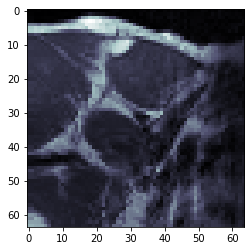

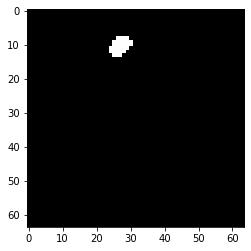

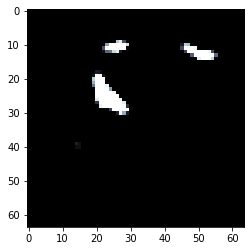

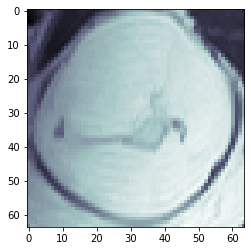

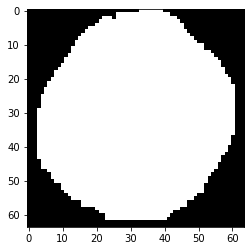

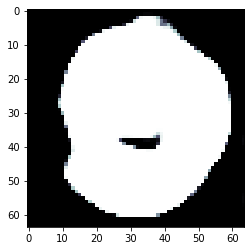

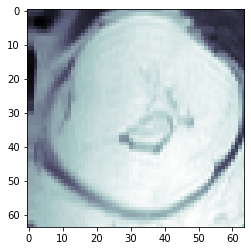

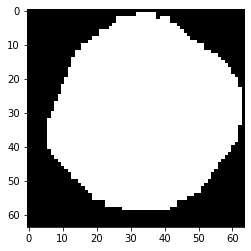

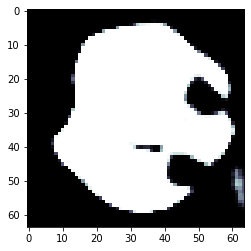

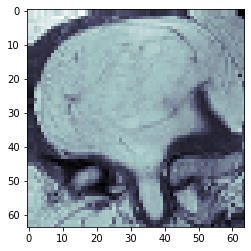

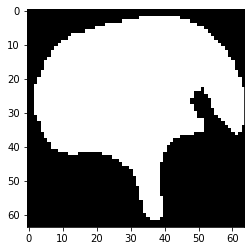

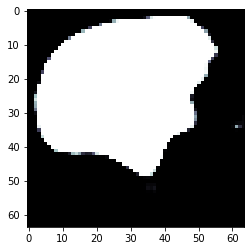

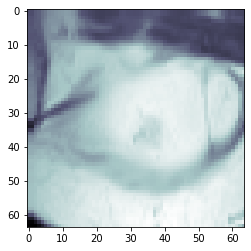

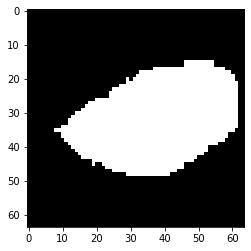

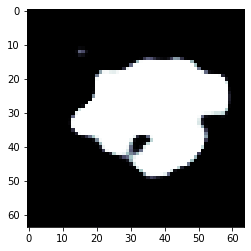

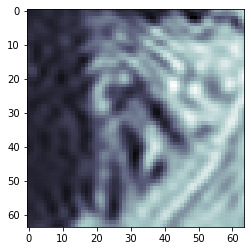

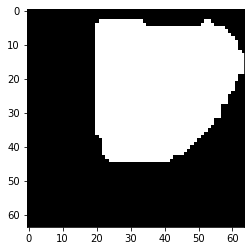

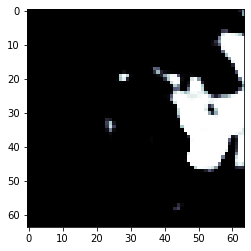

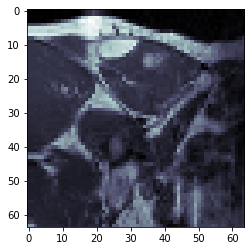

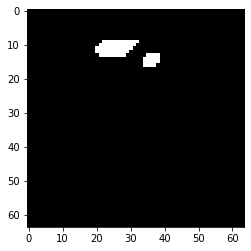

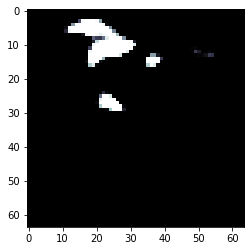

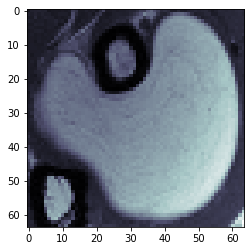

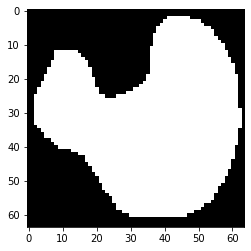

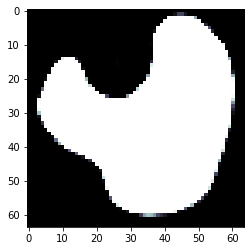

In [4]:
DEVICE = 'cuda'
import matplotlib.pyplot as plt
best_model = torch.load('./best_model.pth')
x, y = niftiGen.get_batch(chunk_size=(64,64,1), batch_size=16 )
x_new = np.zeros((16,1,64,64))
for i in range(16):
    temp = x[i,:,:,:]
    temp1 = np.transpose(temp,(2,0,1))
    x_new[i,:,:,:] = temp1
y_new = np.zeros((16,1,64,64))
for i in range(16):
    temp = y[i,:,:,:]
    temp1 = np.transpose(temp,(2,0,1))
    y_new[i,:,:,:] = temp1
inputs, targets = torch.tensor(x_new, dtype=torch.double).to(DEVICE), torch.tensor(y_new, dtype=torch.double).to(DEVICE)
prob = best_model.predict(inputs)
x1 = inputs.to('cpu')
x2 = targets.to('cpu')
x3 = prob.to('cpu').detach().numpy()

for idx in range(16):
    plt.figure()
    plt.imshow(x1[idx,0,:,:], cmap = plt.cm.bone)
    plt.figure()
    plt.imshow(x2[idx,0,:,:], cmap = plt.cm.bone)
    plt.figure()
    plt.imshow(x3[idx,0,:,:], cmap = plt.cm.bone)
    

In [2]:
gc.collect()
torch.cuda.empty_cache()
x_data_train = './data/image_val'
y_data_train = './data/label_val'

In [3]:
# define the NiftiGenerator
niftiGen = NiftiGenerator.PairedNiftiGenerator()
# get augmentation options (see help for get_default_augOptions for more details! )
niftiGen_augment_opts = NiftiGenerator.PairedNiftiGenerator.get_default_augOptions()
niftiGen_augment_opts.hflips = True
niftiGen_augment_opts.vflips = True
#niftiGen_augment_opts.rotations = 5
#niftiGen_augment_opts.scalings = .1
# get normalization options ( see help for get_default_normOptions for more details! )
niftiGen_norm_opts = NiftiGenerator.PairedNiftiGenerator.get_default_normOptions()
niftiGen_norm_opts.normXtype = 'auto'
niftiGen_norm_opts.normYtype = 'none'
#niftiGen_norm_opts.normYoffset = 0
#niftiGen_norm_opts.normYscale = 50000
# initialize the generator (where x_data_train and y_data_train are either a paths to a single folder or lists of Nifti files)
niftiGen.initialize( x_data_train, y_data_train, augOptions=niftiGen_augment_opts, normOptions=niftiGen_norm_opts )
## in your training function you will then call something like:
#NiftiGenerator.generate_chunks( niftiGen, chunk_size=(32,32,32), batch_size=64 ) 
## to generate a batch of 64, 32x32x32 chunks of paired data

2021-09-10 01:46:15,197 NiftiGenerator INFO     6 datasets were found for X
2021-09-10 01:46:15,198 NiftiGenerator INFO     6 datasets were found for Y
2021-09-10 01:46:15,198 NiftiGenerator INFO     X normalization is auto. Computing normalizations now...


In [1]:
import segmentation_models_pytorch as smp
import torch
import numpy as np
import NiftiGenerator
import gc
import torch.nn.functional as F

In [9]:
import nibabel as nib
import os
from glob import glob
x_data_dir = './data/image'
y_data_dir = './data/label'
inputFilesX1 = sorted( glob( os.path.join(x_data_dir,'*.nii.gz'),recursive=True) + glob( os.path.join(x_data_dir,'*.nii'),recursive=True) )
inputFilesY1 = sorted( glob( os.path.join(y_data_dir,'*.nii.gz'),recursive=True) + glob( os.path.join(y_data_dir,'*.nii'),recursive=True) )
inputFilesX2 = sorted( glob( os.path.join(x_data_train,'*.nii.gz'),recursive=True) + glob( os.path.join(x_data_train,'*.nii'),recursive=True) )
inputFilesY2 = sorted( glob( os.path.join(y_data_train,'*.nii.gz'),recursive=True) + glob( os.path.join(y_data_train,'*.nii'),recursive=True) )

In [11]:
inputFilesX = sorted(inputFilesX1 + inputFilesX2)
inputFilesY = sorted(inputFilesY1 + inputFilesY2)

In [69]:
all_features = []
for i in range(len(inputFilesX)):
    curr_img = nib.load(inputFilesX[i]).get_fdata()
    offset = np.mean(curr_img)
    scale = np.std(curr_img)
    curr_img = (curr_img - offset) / scale
    #print(int(curr_img.shape[2]))
    #print(int(curr_img.shape[2]/2-4))
    #print(int(curr_img.shape[2]/2+3))
    #print('\n')
    z0 = int(curr_img.shape[2]/2-4)
    z1 = int(curr_img.shape[2]/2+4)
    map_list = []
    for z in range(z0,z1):
        current_layer = curr_img[:,:,z]
        inputX = np.expand_dims(np.expand_dims(current_layer, axis=0), axis=0)
        curr_input = torch.tensor(inputX, dtype=torch.double).to(DEVICE)
        #print(curr_input.shape)
        feat = best_model.encoder(curr_input)
        #print(len(feat))
        #print(feat[0].shape)
        #print(feat[1].shape)
        #print(feat[2].shape)
        #print(feat[3].shape)
        #print(feat[4].shape)
        #print(feat[5].shape)
        map_list.append(feat[5].view(-1))
    feat_map = torch.stack(map_list, dim=0).view(-1).to('cpu').detach().numpy()
    #print(feat_map.shape)
    patient = inputFilesX[i].split('/')[-1].split('.')[0]
    row = np.concatenate(([patient], feat_map), axis=0).tolist()
    all_features.append(row)
#print(len(all_features[0]))
#print(len(all_features))

65537
56


In [24]:
Ximg = nib.load(inputFilesX[0]).get_fdata()
mean = np.mean(Ximg)
mean = np.mean(Ximg)

In [40]:
print(best_model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [72]:
import pandas as pd
col_name = ['patient'] + list(range(len(all_features[0])-1))
df = pd.DataFrame(all_features, columns =col_name)

In [74]:
df.to_csv('cnn_features.csv', encoding='utf-8', index=False)